In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import glob
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [6]:
plt.rcParams['figure.figsize'] = (12,10)
plt.style.use('bmh')

## Data pre-processing

In [282]:
#netcdf path
nc_pace_path = '../../hydropt_4_sent3/data/interim/D20200125_125223_PACE_FF0014/*.nc'
nc_olci_path = '../../hydropt_4_sent3/data/interim/D20190813_141238_OLCI_SUNTHETA_ALL/*.nc'

In [8]:
ds = xr.open_mfdataset(nc_pace_path, combine='by_coords')

In [9]:
# subset dataset for just above (Ed) and below (IOPs) sea-surface parameter values
ds = ds.isel(geom_depth=0, geom_depth_air=0, suntheta=0)

In [10]:
# calculate rrs
ds['rrs'] = ds.RADMa/ds.Ed

In [13]:
# subset for NADIR viewing angles
ds_nadir = ds.isel(phi=0, fmu=9)

In [14]:
# select total absorption, total backscatter coefficients and Rrs
var = ['acoef', 'bbcoef', 'rrs']
ds_nadir = ds_nadir[var]

In [15]:
ds_df = ds_nadir.to_dataframe()

In [23]:
ds_df.reset_index(inplace=True)

In [16]:
wbands = ds_df.index.get_level_values('wavelength').unique()

### Sun zenith angle 60 degrees
Load Hydrolight data for OLCI bands at SZA 60 degrees. Validate IOCCG and CCRR on OLCI bands.

In [289]:
# select all files with SZA at 60 deg.: files 6000 - 6999
nc_olci = glob.glob(nc_olci_path)
nc_olci.sort()
nc_olci_sza_60 = nc_olci[6000:7000]

In [291]:
ds_olci = xr.open_mfdataset(nc_olci_sza_60, combine='by_coords')

In [308]:
# subset dataset for just above (Ed) and below (IOPs) sea-surface parameter values
ds_olci = ds_olci.isel(geom_depth=0, geom_depth_air=0, suntheta=0)

In [310]:
# calculate rrs
ds_olci['rrs'] = ds_olci.RADMa/ds_olci.Ed

In [311]:
# subset for NADIR viewing angles
ds_olci_nadir = ds_olci.isel(phi=0, fmu=9)

In [312]:
ds_olci_nadir = ds_olci_nadir[var]

In [321]:
df_olci = ds_olci_nadir.to_dataframe()

In [386]:
df_olci.reset_index(inplace=True)

## IOCCG dataset validation

In [826]:
# load IOCCG IOP-AOPs
ioccg = pd.read_csv('./data/ccrr_rrs_iop_sza_60.csv', index_col='wavelength')

In [757]:
def filter_iop_bounds(x):
    # define lookup table
    hydropt_lut = df_olci.set_index('wavelength')
    # get wavelength
    wl = x.name
    # filter
    mask = ((x.a < hydropt_lut.loc[wl].acoef.max()) &
            (x.bb < hydropt_lut.loc[wl].bbcoef.max()))
    
    return x[mask]

In [758]:
model = make_pipeline(PolynomialFeatures(), linear_model.LinearRegression())

In [759]:
def predict_rrs(x):
    '''predict Rrs using polynomial'''
    # define lookup table
    hydropt_lut = df_olci.set_index('wavelength')
    # get wavelength
    wl = x.name
    X_ioccg = np.log(x[['a','bb']])
    X_hydropt = np.log(hydropt_lut.loc[wl][['acoef','bbcoef']])
    Y_hydropt = np.log(hydropt_lut.loc[wl]['rrs'])
    model.set_params(polynomialfeatures__degree=4)
    rrs_hat = model\
                .fit(X_hydropt, Y_hydropt)\
                .predict(X_ioccg)
    
    return np.exp(rrs_hat)

In [760]:
s = ioccg.groupby('wavelength')\
            .apply(filter_iop_bounds)

In [761]:
s = s.groupby('wavelength')\
     .apply(predict_rrs)

In [762]:
x = ioccg.groupby('wavelength')\
        .apply(filter_iop_bounds)

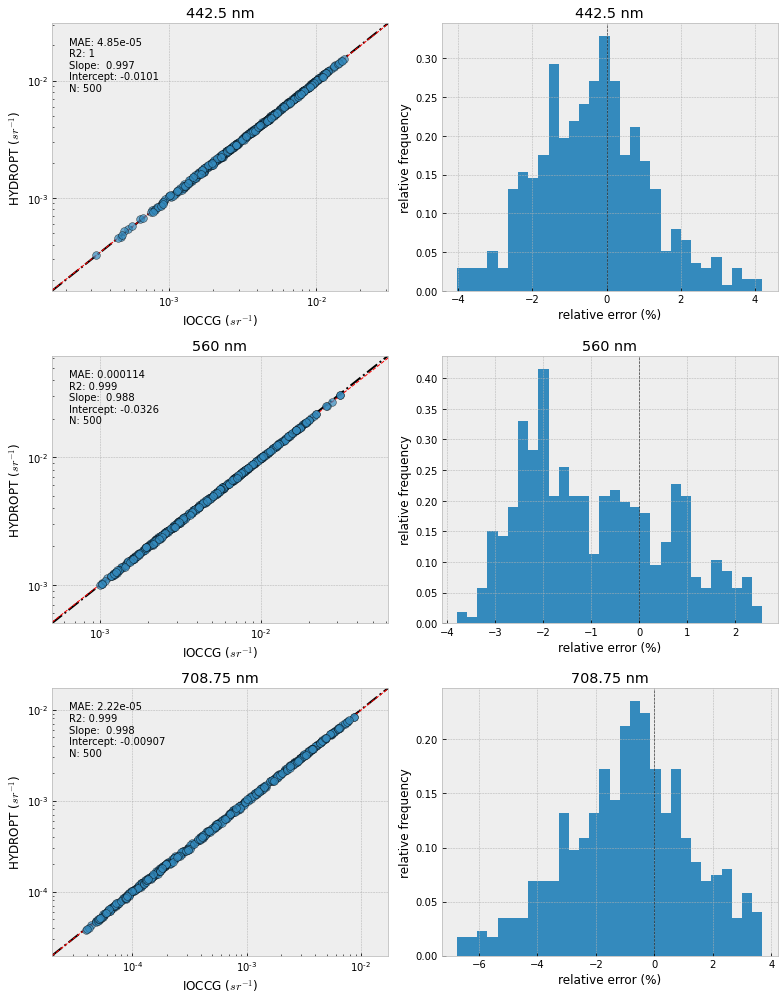

In [769]:
fig, ax = plt.subplots(3,2, figsize=(11,14))
#ax = ax.flatten()
#cols = np.log10(ioccg.set_index('wavelength').loc[400]['a_nw'])
olci = [442.50,560, 708.75]
#olci = [400,560]

for (axs, wl) in zip(ax, olci):
    
    X = x.loc[wl]['Rrs'].values
    Y = s.loc[wl]
    #cols = np.log10(x.loc[wl]['bb_dm'].values)
    X_log, Y_log = np.log10(X).reshape(-1,1), np.log10(Y).reshape(-1,1)
    # determine min and max of axes
    ax_min, ax_max = [np.min(X)*.5, np.max(X)*2]
    # calculate regression stats
    lm = linear_model.LinearRegression().fit(X_log, Y_log)
    # regression line
    x_log_range = np.logspace(np.log10(ax_min), np.log10(ax_max))
    lm_line = np.power(10, lm.coef_[0][0]*np.log10(x_log_range)+lm.intercept_[0])
    # plot scatter
    axs[0].plot(x_log_range,  lm_line, color='red', linewidth=1, linestyle='--')
        
    cax = axs[0].scatter(X, Y, vmin=-2, vmax=-1, c=None, cmap='viridis',
                      edgecolor='black', linewidth=.5, alpha=.7, s=60, zorder=5)
    
    axs[0].plot([ax_min,ax_max],[ax_min,ax_max], c='black', linestyle='-.', zorder=0)
    # stats as string
    stat_str = 'MAE: {0:.3g}\nR2: {1:.3g}\nSlope: {2: .3g} \nIntercept: {3: .3g} \nN: {4}'\
            .format(mean_absolute_error(X,Y),
                    r2_score(X,Y),
                     lm.coef_[0][0],
                     lm.intercept_[0],
                    len(Y))
    
    axs[0].annotate(stat_str, xy=(.05, .95), xycoords='axes fraction', ha='left', va='top')
    
    axs[0].loglog()
    axs[0].set_xlim(ax_min, ax_max)
    axs[0].set_ylim(ax_min, ax_max)
    axs[0].set_xlabel('IOCCG ($sr^{-1}$)')
    axs[0].set_ylabel('HYDROPT ($sr^{-1}$)')
    axs[0].set_title(str(wl) + ' nm')
    #axs[0].grid(which='both')
    
    #histogram
    r_error = 100*(Y-X)/X
    axs[1].hist(r_error, bins=30, density=True)
    axs[1].set_xlabel('relative error (%)')
    axs[1].set_ylabel('relative frequency')
    axs[1].set_title(str(wl) + ' nm')
    axs[1].axvline(0, linestyle='--', linewidth=.7, color='black', alpha=.7)
#fig.colorbar(cax)
plt.tight_layout()

In [ ]:
x